In [5]:
import json, os, toml, sys

import matplotlib
from langchain.graphs.networkx_graph import NetworkxEntityGraph, KnowledgeTriple
from langchain_together import Together
from langchain.indexes import GraphIndexCreator
from langchain.chains import GraphQAChain
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



> Entering new GraphQAChain chain...
Entities Extracted:
 Ostionada
Full Context:


> Finished chain.


{}

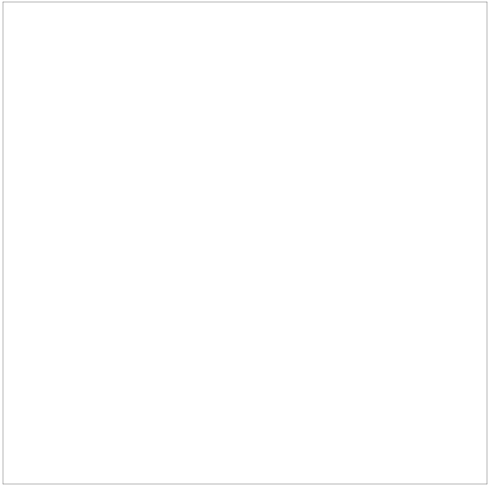

In [7]:
def load_api_key(toml_file_path="secrets.toml"):
    try:
        with open(toml_file_path, 'r') as file:
            data = toml.load(file)
    except FileNotFoundError:
        print(f"File not found: {toml_file_path}", file=sys.stderr)
        return
    except toml.TomlDecodeError:
        print(f"Error decoding TOML file: {toml_file_path}", file=sys.stderr)
        return
    # Set environment variables
    for key, value in data.items():
        os.environ[key] = str(value)

def read_json_triplets(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            return [(item['sujeto'], item['predicado'], item['objeto']) for item in data if 'sujeto' in item and 'predicado' in item and 'objeto' in item]
    except json.JSONDecodeError:
        print(f"Error al leer el archivo JSON: {file_path}")
        return []


load_api_key()

# Buscar archivos que comiencen con "triplets" y terminen en ".txt"
files = [f for f in os.listdir() if f.startswith("triplets") and f.endswith(".txt")]

kg = []
for file_name in files:
    file_path = os.path.join(os.getcwd(), file_name)
    triplets = read_json_triplets(file_path)
    kg.extend(triplets)

graph = NetworkxEntityGraph()
# Añadir los triplets al graph
for (node1, relation, node2) in kg:
    graph.add_triple(KnowledgeTriple(node1, relation, node2))

## Preguntar
question = "¿Cuándo y dónde es la Ostionada?"
chain = GraphQAChain.from_llm(llm=Together(together_api_key=os.environ.get("TOGETHER_API_KEY"),model="microsoft/WizardLM-2-8x22B",temperature=0, max_tokens=400), graph=graph, verbose=True)
chain.invoke(question)

'''
> Entering new GraphQAChain chain...
Entities Extracted:
 Ostionada
Full Context:
Ostionada se celebra domingo 28 de enero
Ostionada ubicación plaza de San Antonio, Cádiz
Ostionada celebra edición número 37

> Finished chain.
'''

# Dibujar el grafo
# Create directed graph
G = nx.DiGraph()
for node1, relation, node2 in kg:
    ## Añadimos solamente los 50 primeros nodos
    if len(G.nodes) >= 80:
        break
    G.add_edge(node1, node2, label=relation)

# Plot the graph
plt.figure(figsize=(25, 25), dpi=25)
pos = nx.spring_layout(G, k=2, iterations=50, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=5000)
nx.draw_networkx_edges(G, pos, edge_color='blue', edgelist=G.edges(), width=2)
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

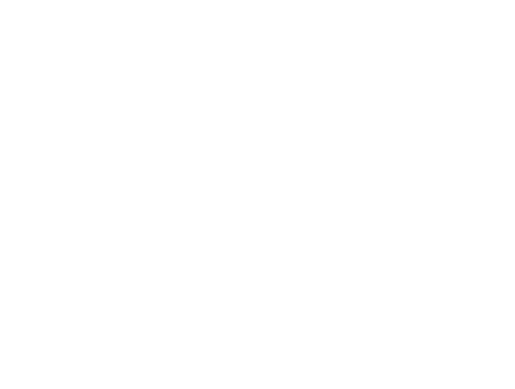

In [8]:
# Display the plot
plt.axis('off')
plt.show()

In [ ]:
plt.savefig('graph.png')